In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets as D
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import DisjointSet
import random

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from tqdm import tqdm

# Loading the Dataset

In [2]:
# the total nr of points inside the sample dataset
N_SAMPLES = 1500

noisy_circles = D.make_circles(n_samples=N_SAMPLES, factor=.5, noise=.05)
noisy_circles

(array([[-0.10359274,  0.87559543],
        [-0.79571331, -0.51994159],
        [ 0.1863536 ,  0.50065046],
        ...,
        [ 0.95772067,  0.24722536],
        [-0.23099636, -0.96088551],
        [ 0.41183195, -0.16848623]]),
 array([0, 0, 1, ..., 0, 0, 1], dtype=int64))

In [3]:
def sklearn_scatter_to_df(sklearn_scatter_data):
    return pd.DataFrame(data={
        'x': [sklearn_scatter_data[0][i][0] for i in range(len(sklearn_scatter_data[0]))],
        'y': [sklearn_scatter_data[0][i][1] for i in range(len(sklearn_scatter_data[0]))],
        'cluster': [sklearn_scatter_data[1][i] for i in range(len(sklearn_scatter_data[0]))]
    })

<Axes: xlabel='x', ylabel='y'>

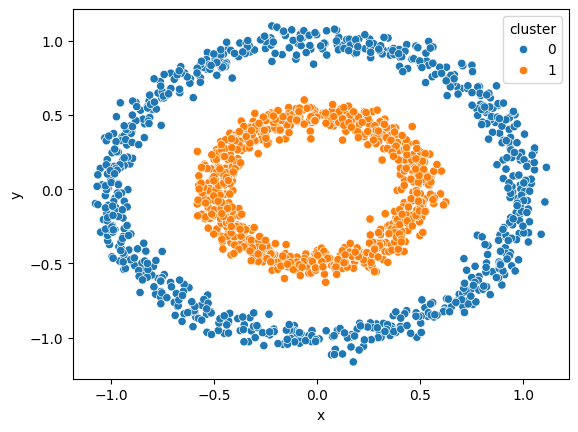

In [4]:
sns.scatterplot(sklearn_scatter_to_df(noisy_circles), x='x', y='y', hue='cluster')

# The Implementation

In [5]:
spark = (SparkSession
    .builder
    .appName("MST")
    .getOrCreate())

In [6]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=MST>

In [7]:
class Edge:
    def __init__(self, x, y, w):
        self.x = x
        self.y = y
        self.w = w

    def __repr__(self):
        return '{{({}, {}), w:{}}}'.format(self.x, self.y, self.w)

In [8]:
def MSTKruskal(edges):
    result = []
    
    disjoint_set = DisjointSet()
    edges.sort(key=lambda e: e.w)

    for edge in edges:
        disjoint_set.add(edge.x)
        disjoint_set.add(edge.y)
        
        if not disjoint_set.connected(edge.x, edge.y):
            disjoint_set.merge(edge.x, edge.y)
            result.append(edge)

    return result

In [9]:
def MSTDense(n_vertices, edges, epsilon):
    n = n_vertices
    m = len(edges)
    y = n ** (1 + epsilon)

    while m > y:
        print('edges: {}'.format(m))
        
        # floor or ceil?
        x = math.ceil(m / y)
    
        edge_partition = []
        for i in range(x):
            edge_partition.append([])

        for edge in edges:
            i = hash((edge.x, edge.y, edge.w)) % x
            edge_partition[i].append(edge)

        print('created partition')

        edges = sum(sc.parallelize(edge_partition)
            .map(lambda x: MSTKruskal(x))
            .collect(), [])
        m = len(edges)

        print('updated edges')
        
    return MSTKruskal(edges) 

# Testing it on the noisy circles dataset

In [10]:
def get_distance_graph_edges(points):
    # compute the distance matrix
    d_matrix = distance_matrix(points, points, threshold=1000000)
    d_matrix
    
    # convert the distance matrix to edge list
    edges = []
    for i in range(len(d_matrix[0])):
        for j in range(i + 1, len(d_matrix[0])):
            edges.append(Edge(i, j, d_matrix[i][j]))

    return edges

In [11]:
n_vertices = len(noisy_circles[0])
edges = get_distance_graph_edges(noisy_circles[0])

In [ ]:
result = MSTDense(n_vertices, edges, 0.2)

edges: 1124250
created partition
updated edges
edges: 260790
created partition


In [ ]:
def sklearn_scatter_to_df(sklearn_scatter_data, cluster_mapping):
    return pd.DataFrame(data={
        'x': [sklearn_scatter_data[i][0] for i in range(len(sklearn_scatter_data))],
        'y': [sklearn_scatter_data[i][1] for i in range(len(sklearn_scatter_data))],
        'cluster': [str(cluster_mapping[i]) for i in range(len(sklearn_scatter_data))]
    })

In [ ]:
def print_clustering(points, result, n_clusters):
    disjoint_set = DisjointSet(elements=[i for i in range(len(points))])
    for i in range(len(points) - n_clusters):
        edge = result[i]
        disjoint_set.merge(edge.x, edge.y)

    df = sklearn_scatter_to_df(points, [ str(disjoint_set.subsets().index(disjoint_set.subset(i))) for i in range(len(points)) ])
    plot = sns.scatterplot(df, x='x', y='y', hue='cluster')
    plot.get_legend().remove()

In [ ]:
print_clustering(noisy_circles[0], result, 25)

In [ ]:
print_clustering(noisy_circles[0], result, 10)

In [ ]:
print_clustering(noisy_circles[0], result, 2)